# Introduction 
## Dataset Details
 - UrbanSound8K was extended by adding 2400 gunshot files to it from AudioSet & MIVIA audio events data set. 
     
    - "UrbanSound8K.csv" was modified accordingly.

- 74 more gunshots were added which were downloaded from:
http://soundbible.com/tags-gun.html

    - "UrbanSound8K-modified.csv" was created for latest version of dataset.
    - "US8K-Binary" refers to new dataset


- Moreover, UrbanSound8K was changed for binary classification with new classes: 
    - no_gun_shot (8358 files, which is 3 times when compared with other class.)
    - gun_shot (2848)
    - Total files are 11206.
- Lastly, folds were increased from 10 to 40.

# Retriving and Visualizing the Dataset


In [19]:
import matplotlib.pyplot as plt
import librosa
import pandas as pd
import numpy as np
import sys
import os

# for visualization
import scipy
from scipy import signal
import IPython.display as ipd

## Get the classes
Reading all class names along with their numeric labels from csv file.

In [20]:
dataset_dir = r".\UrbanSound8K-binary"
metadata_csv = r".\UrbanSound8K-binary\metadata\UrbanSound8K-modified.csv"
audio_dir = r".\UrbanSound8K-binary\audio"
metadata = pd.read_csv(metadata_csv)
df = pd.DataFrame(metadata)
classes = df[['classID', 'class']].as_matrix().tolist()
classes = set(['{} {}'.format(c[0], c[1]) for c in classes])
classes = np.array([c.split(' ') for c in classes])
classes = {k: v for k, v in classes}
print(classes)

{'0': 'no_gun_shot', '1': 'gun_shot'}


C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


## Exploring Dataset

              count
class              
gun_shot     2774.0
no_gun_shot  8358.0

Total examples = 11132.0
Ratio (gunshot//no_gunshot) = 0.3318975831538646


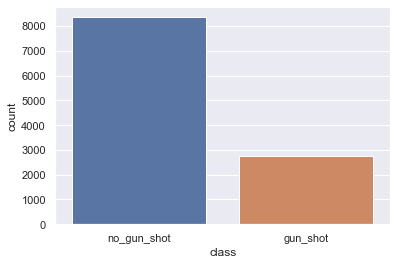

In [4]:
import seaborn as sns

class_count = pd.DataFrame(df.groupby("class").describe()["fsID"]["count"])
print(class_count)
print()
num_gunshots = class_count["count"][0]
num_no_gunshots = class_count["count"][1]
print("Total examples = " + str(num_no_gunshots+num_gunshots))
print("Ratio (gunshot//no_gunshot) = " + str(num_gunshots/num_no_gunshots))

sns.set(style="darkgrid")
ax = sns.countplot(x="class", data=df)

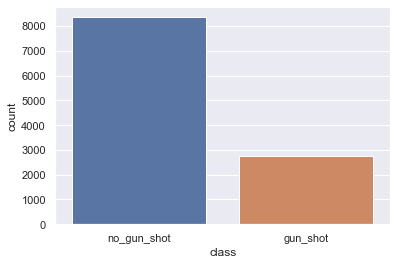

## Visualizing Dataset

Select files for visualization

In [6]:
from tkinter import*
# Create Tk root
root = Tk()
# Hide the main window
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)

from tkinter import filedialog
selected_files = filedialog.askopenfilename(multiple=True)

%gui tk

In [7]:
# use this cell to paste file addresses manually
# selected_files = ["xyz.mp3", "D://abc.mp3"]

In [8]:
from librosa import display
for file in selected_files:
    # sr = sample rate
    x, sr = librosa.load(file, sr=44100)
    print(type(x), type(sr))
    print(x.shape, sr)
    plt.figure(figsize=(14, 5))
    librosa.display.waveplot(x, sr=sr)
    print(file.split("/")[-1])
    

# Extracting Features of Audio Files

In [21]:
import struct

class WavFileHelper():
    
    def read_file_properties(self, filename):
        wave_file = open(filename,"rb")
        
        riff = wave_file.read(12)
        fmt = wave_file.read(36)
        
        num_channels_string = fmt[10:12]
        num_channels = struct.unpack('<H', num_channels_string)[0]

        sample_rate_string = fmt[12:16]
        sample_rate = struct.unpack("<I",sample_rate_string)[0]
        
        bit_depth_string = fmt[22:24]
        bit_depth = struct.unpack("<H",bit_depth_string)[0]

        return (num_channels, sample_rate, bit_depth)

In [22]:
# Load various imports 
import pandas as pd
import os
import librosa
import librosa.display

wavfilehelper = WavFileHelper()

audiodata = []
for index, row in metadata.iterrows():
    file_name = os.path.join(audio_dir, 'fold'+str(row["fold"])+'\\', str(row["file_name"]))
    data = wavfilehelper.read_file_properties(file_name)
    audiodata.append(data)

# Convert into a Panda dataframe
audiodf = pd.DataFrame(audiodata, columns=['num_channels','sample_rate','bit_depth'])

## Checking Audio Properties

2    0.71802
1    0.28198
Name: num_channels, dtype: float64


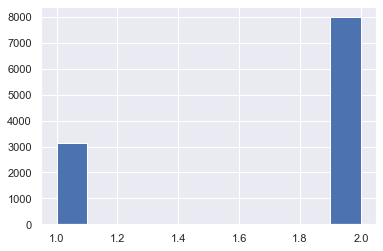

In [23]:
print(audiodf.num_channels.value_counts(normalize=True))
audiodf.num_channels.hist()

16    0.732842
24    0.247305
32    0.015181
8     0.003863
4     0.000808
Name: bit_depth, dtype: float64


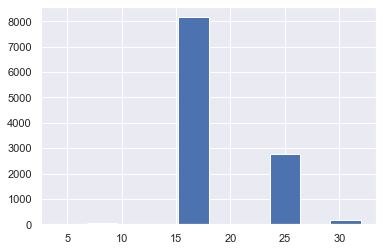

In [24]:
print(audiodf.bit_depth.value_counts(normalize=True))
audiodf.bit_depth.hist()

44100     0.482393
48000     0.224757
32000     0.215954
96000     0.054797
24000     0.007366
16000     0.004042
22050     0.003953
11025     0.003503
192000    0.001527
8000      0.001078
11024     0.000629
Name: sample_rate, dtype: float64


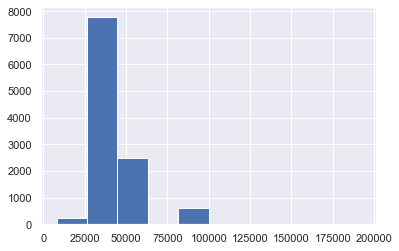

In [25]:
print(audiodf.sample_rate.value_counts(normalize=True))
audiodf.sample_rate.hist()

In [26]:
audiodata[0]

(2, 44100, 16)

## Preprocessing with Librosa for better results

In [27]:
def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
#         print(audio.dtype)
#         print(type(audio))
#         print(len(audio))
#         print(audio)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None 
     
    return mfccsscaled

def extract_features_arr(audio_arr, sample_rate):
   
    mfccs = librosa.feature.mfcc(y=audio_arr, sr=sample_rate, n_mfcc=40)
    mfccsscaled = np.mean(mfccs.T,axis=0)
     
    return mfccsscaled

In [ ]:
# # Set the path to the full UrbanSound dataset 
# features = []

# # Iterate through each sound file and extract the features 
# for index, row in metadata.iterrows():
    
#     file_name = os.path.join(audio_dir,'fold'+str(row["fold"])+'\\',str(row["file_name"]))
#     class_label = row["classID"]
#     data = extract_features(file_name)
#     features.append([data, class_label])

# # Convert into a Panda dataframe 
# featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

# print('Finished feature extraction from ', len(featuresdf), ' files')

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class SoundPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        self.df = df
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        # Set the path to the full UrbanSound dataset 
        features = []

        # Iterate through each sound file and extract the features 
        for index, row in X.iterrows():
            file_name = os.path.join(audio_dir,'fold'+str(row["fold"])+'\\',str(row["file_name"]))
            class_label = row["classID"]
            data = extract_features(file_name)
            features.append([data, class_label])

        # Convert into a Panda dataframe 
        featuresdf = pd.DataFrame(features, columns=['feature','class_label'])
        return featuresdf
sound_preprocessor = SoundPreprocessor()
featuresdf = sound_preprocessor.transform(metadata)
print('Finished feature extraction from ', len(featuresdf), ' files')

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class SoundPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        self.df = df
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        # Set the path to the full UrbanSound dataset 
        features = []

        # Iterate through each sound file and extract the features 
        for index, row in X.iterrows():
            file_name = os.path.join(audio_dir,'fold'+str(row["fold"])+'\\',str(row["file_name"]))
            class_label = row["classID"]
            data = extract_features(file_name)
            features.append([data, class_label])

        # Convert into a Panda dataframe 
        featuresdf = pd.DataFrame(features, columns=['feature','class_label'])
        X = np.array(featuresdf.feature.tolist())
        return X
sound_preprocessor = SoundPreprocessor()
featuresdf = sound_preprocessor.transform(metadata)
print('Finished feature extraction from ', len(featuresdf), ' files')

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class SoundFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        self.df = df
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        # Set the path to the full UrbanSound dataset 
        features = []

        # Iterate through each sound file and extract the features 
        for index, row in X.iterrows():
            file_name = os.path.join(audio_dir,'fold'+str(row["fold"])+'\\',str(row["file_name"]))
            class_label = row["classID"]
            data = extract_features(file_name)
            features.append([data, class_label])

        # Convert into a Panda dataframe 
        featuresdf = pd.DataFrame(features, columns=['feature','class_label'])
        X = np.array(featuresdf.feature.tolist())
        y = np.array(featuresdf.class_label.tolist())
        # Encode the classification labels
        le = LabelEncoder()
        yy = to_categorical(le.fit_transform(y))

        return X, y
    
# class LabelTransformer(BaseEstimator, TransformerMixin):
#     def __init__(self): # no *args or **kargs
#         self.df = df
#     def fit(self, X=None, y):
#         return self  # nothing else to do
#     def transform(self, X, y=None):
#         y = y.tolist()

#         # Encode the classification labels
#         le = LabelEncoder()
#         yy = to_categorical(le.fit_transform(y))
#         return yy

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ('feature_extractor', SoundFeatureExtractor(), ["feature"]),
        ('label_transformer', LabelTransformer(), ["class_label"]),
    ])

featuresdf = full_pipeline.fit_transform(housing)

**Use this cell to train data on specific set of files only**
I used it to better fit on specific files before training on whole dataset. 


In [ ]:
"""
Use this cell to train data on specific set of files only 

"""
# # Set the path to the full UrbanSound dataset 
# features_custom = []

# path_to_files = r"D:\ML\Datasets\Sound\Downloaded Gunshots\renamedfiles"
# # Iterate through each sound file and extract the features 
# for file in os.listdir(path_to_files):
#     file_name = os.path.join(path_to_files, file)
#     class_label = 1
#     data = extract_features(file_name)
#     features_custom.append([data, class_label])

# # Convert into a Panda dataframe 
# featuresdf_custom = pd.DataFrame(features_custom, columns=['feature','class_label'])

# print('Finished feature extraction from ', len(featuresdf_custom), ' files')

# del featuresdf
# featuresdf = featuresdf_custom

In [15]:
featuresdf["feature"][0].shape

(40,)

## Saving & Loading Features Dataframe 

Instead of generating features each time, use this cell to save/load features dataframe.

In [28]:
# using HDFStore for high speed data reading
backup = pd.HDFStore('Backups//dataframes_backup.h5', 'r+')

# uncomment to store featuresdf again
# backup["featuresdf"] = featuresdf
# backup["featuresdf_custom"] = featuresdf_custom

# loading from featuresdf from .h5 file
featuresdf = backup["featuresdf"]
backup.close()

# Splitting Dataset, Defining Model, Training & Evaluation

## One-hot Encoding and Splitting of Dataset

In [29]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())
print(X.shape)
print(y.shape)

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=.01, random_state = 42)

Using TensorFlow backend.


(11132, 40)
(11132,)


## Defining CNN Model

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

In [14]:
num_rows = 4
num_columns = 10
num_channels = 1

In [15]:
x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

num_labels = yy.shape[1]
filter_size = 2

In [16]:
# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding="same", input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='sigmoid'))

## Model Compilation

In [17]:
# Compile the model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 4, 10, 16)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 10, 16)         0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 10, 16)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 10, 32)         2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 10, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 10, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 10, 64)         8

## Training & Saving Checkpoints with Best Validation Accuracy

In [101]:
from tensorflow.keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 50
num_batch_size = 50

checkpointer = ModelCheckpoint(filepath='best_weights_temp.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

W0811 18:58:30.735896 17032 deprecation.py:323] From C:\Users\G3NZ\Anaconda3\envs\tf-2.0\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 11020 samples, validate on 112 samples
Epoch 1/50
11000/11020 [============================>.] - ETA: 0s - loss: 0.3462 - accuracy: 0.8515 ETA: 0s - loss: 0.3592 - accuracy: 
Epoch 00001: val_loss improved from inf to 0.18600, saving model to best_weights_temp.hdf5
11020/11020 [==============================] - 3s 258us/sample - loss: 0.3462 - accuracy: 0.8517 - val_loss: 0.1860 - val_accuracy: 0.9643
Epoch 2/50
10900/11020 [============================>.] - ETA: 0s - loss: 0.1834 - accuracy: 0.9309
Epoch 00002: val_loss improved from 0.18600 to 0.13655, saving model to best_weights_temp.hdf5
11020/11020 [==============================] - 2s 213us/sample - loss: 0.1835 - accuracy: 0.9310 - val_loss: 0.1365 - val_accuracy: 0.9643
Epoch 3/50
10900/11020 [============================>.] - ETA: 0s - loss: 0.1459 - accuracy: 0.9450
Epoch 00003: val_loss improved from 0.13655 to 0.11366, saving model to best_weights_temp.hdf5
11020/11020 [==============================] - 2s 217us/s

Epoch 28/50
11000/11020 [============================>.] - ETA: 0s - loss: 0.0526 - accuracy: 0.9809
Epoch 00028: val_loss did not improve from 0.07915
11020/11020 [==============================] - 5s 480us/sample - loss: 0.0526 - accuracy: 0.9809 - val_loss: 0.0890 - val_accuracy: 0.9732
Epoch 29/50
10950/11020 [============================>.] - ETA: 0s - loss: 0.0518 - accuracy: 0.9813
Epoch 00029: val_loss did not improve from 0.07915
11020/11020 [==============================] - 6s 517us/sample - loss: 0.0517 - accuracy: 0.9813 - val_loss: 0.1366 - val_accuracy: 0.9464
Epoch 30/50
10950/11020 [============================>.] - ETA: 0s - loss: 0.0509 - accuracy: 0.9841
Epoch 00030: val_loss did not improve from 0.07915
11020/11020 [==============================] - 7s 593us/sample - loss: 0.0510 - accuracy: 0.9840 - val_loss: 0.0897 - val_accuracy: 0.9643
Epoch 31/50
10950/11020 [============================>.] - ETA: 0s - loss: 0.0492 - accuracy: 0.9829 ETA
Epoch 00031: val_loss 

## Evaluation

In [20]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: {0:.2f}".format(score[1] * 100) + "%")

score = model.evaluate(x_test, y_test, verbose=0)
print("Test Accuracy: {0:.2f}".format(score[1] * 100) + "%")

Training Accuracy: 99.30%
Test Accuracy: 97.32%


## Making Predictions

In [18]:
# load model
model.load_weights("Backups//best_weights_temp.hdf5")

In [19]:
def predict_class(featuresdf):
    pred_index_tensor=tf.argmax(model.predict(featuresdf.reshape(1, x_train.shape[1], x_train.shape[2], x_train.shape[3])), axis=1)
    pred_index_arr = pred_index_tensor.numpy()
    pred_index = str(pred_index_arr[0])
    pred_class = classes[pred_index]
    return (pred_index, pred_class)

def index_to_class(index):
    return classes[str(index)]

### Make prediction on test set

In [21]:
# make prediction on test set file
index = int(input("Enter test set file index (total test files are " + str(len(x_test)) + "):\n"))
print()
class_index, class_name = predict_class(x_test[index])
print("Predicted Class: " + str(class_index))
print("Predicted Class Name: " + str(class_name))
print()
# y_test[index] returns a one hot vector
print("Actual Class: " + index_to_class(np.argmax(y_test[index])))

Enter test set file index (total test files are 112):
50

Predicted Class: 1
Predicted Class Name: gun_shot

Actual Class: gun_shot


### Make prediction on file

In [114]:
from tkinter import*
# Create Tk root
root = Tk()
# Hide the main window
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)

from tkinter import filedialog
selected_files = filedialog.askopenfilename(multiple=True)

%gui tk

In [115]:
no_of_gunshots = 0
no_of_not_gunshots = 0
for i, file in enumerate(selected_files):
    print("Making prediction on file "+str(i)+": " + file.split("/")[-1])
    print()
    f_features = extract_features(file)
    class_index, class_name = predict_class(f_features)
    print("\tPredicted Class: " + str(class_index))
    print("\tPredicted Class Name: " + str(class_name))
    print("__________________________________\n")
    if class_name=="gun_shot":
        no_of_gunshots += 1
    else:
        no_of_not_gunshots += 1
print("No. of gun_shots: ", no_of_gunshots)
print("No. of not_gunshots: ", no_of_not_gunshots)

Making prediction on file 0: cat_2.wav

	Predicted Class: 0
	Predicted Class Name: no_gun_shot
__________________________________

No. of gun_shots:  0
No. of not_gunshots:  1


In [143]:
# use this to play selected files
ipd.Audio(selected_files[0])
# ipd.Audio(data, sample_rate)

## Making Real-time Predictions (For demonstration purposes only)

In [23]:
import queue 
prediction_history = queue.Queue(maxsize=5) 

sample_rate = 44100
threshold = 1 # required number of gunshots, in most recent 5 predictions, 
              # to make final decision
while True:
    gunshot_count = 0
    
    from rcaudio import CoreRecorder
    CR = CoreRecorder(
            time = 4, # How much time to record
            sr = sample_rate # sample rate
            )
    CR.start()
    # CR.stop()
    
    data = [0] * 44100 # initializing the overlapping sound with zeros
    
    while True:
        if not CR.buffer.empty():
            # get every integer from buffer and append in data list
            x = CR.buffer.get()
            data.append(x)
            
            # 4 seconds of recorded sound and 1 second of overlapping sound
            if len(data)//44100 == 5:
                break
                
    data = np.array(data, dtype="float32")
#     print("Making prediction on given array")
    
    # extract features to make prediction
    arr_features = extract_features_arr(data, sample_rate)
#     print(arr_features)
    class_index, class_name = predict_class(arr_features)
#     print("\tPredicted Class: " + str(class_index))
#     print("\tPredicted Class Name: " + str(class_name))
#     print("__________________________________\n")
    
    # overlapping last 1 second
    data = data.tolist()[-44100:] 
    
    prediction_history.put(class_index) # add new result
    
    if prediction_history.full():
        while prediction_history.empty() != True:
            elem = prediction_history.get()
            if elem == "1": # gunshot detected
                gunshot_count += 1
        
        if gunshot_count >= threshold:
            print("Gunshots Detected!")


Gunshots Detected!
Gunshots Detected!
Gunshots Detected!
Gunshots Detected!
Gunshots Detected!
Gunshots Detected!
Gunshots Detected!
Gunshots Detected!
Gunshots Detected!
Gunshots Detected!
Gunshots Detected!
Gunshots Detected!
Gunshots Detected!


KeyboardInterrupt: 